# Evaluación de modelos cardíacos

Genera máscaras predichas para cada estructura activa, calcula métricas (**Dice**, **IoU**) y estima volúmenes usando los datos en `test/`. Además permite visualizar cortes con la predicción superpuesta sobre la máscara real.


## Requisitos previos

- Ejecutar el notebook desde la raíz del proyecto (`tfm_alvaro`).
- Tener instaladas las dependencias: `torch`, `monai`, `vtk`, `numpy`, `pandas`, `matplotlib`.
- Verificar que `models/` contiene los pesos entrenados y que `test/` incluye estudios y máscaras de referencia.


In [1]:
!pip install -q --upgrade pip
!pip install numpy==1.23.5
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 -f https://download.pytorch.org/whl/cu121
!pip install monai==1.4.0 torchio==0.20.2 vtk==9.3.0 nibabel==5.2.1

  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> No available output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
ERROR: Failed to build 'numpy' when getting requirements to build wheel
Looking in links: https://download.pytorch.org/whl/cu121


In [18]:
 from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from monai.networks.nets import UNet
import vtk
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import matplotlib.pyplot as plt

ROOT = Path("/content/drive/MyDrive/tfm_alvaro")
DATA_ROOT = ROOT / "test"
MODELS_ROOT = ROOT / "models"
OUTPUT_ROOT = ROOT / "output_test"
OUTPUT_ROOT.mkdir(exist_ok=True)

HEART_PARTS = [
    "LV",
    "LV_Epi",
    "RV_Epi",
    "LV_Endo",
    "RV_Endo",
    "Core_Surface",
    "Border_Zone_Surface",
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

ENABLE_VISUALIZATION = True
VISUALIZE_STEP = None  # None muestra el corte central; usa un entero para espaciar cortes
VISUALIZE_HEART_PARTS = None  # p.ej. {"LV", "LV_Endo"} para limitar partes
VISUALIZE_PATIENTS = None  # p.ej. {"paciente49", "pacientetest"} para limitar pacientes


Usando dispositivo: cuda


In [20]:
def resolve_model_path(heart_part: str):
    candidates = [
        MODELS_ROOT / heart_part / f"model_3dunet_{heart_part}.pth",
        MODELS_ROOT / f"model_3dunet_{heart_part}.pth",
        MODELS_ROOT / heart_part / f"model_{heart_part}.pth",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return None


def get_patient_data_dir(patient_root: Path):
    candidates = [
        patient_root,
        patient_root / "mask",
        patient_root / "mascaras",
    ]
    for directory in candidates:
        study_file = directory / "Study.vtk"
        if study_file.exists():
            return directory
    return None


def find_mask_path(data_dir: Path, heart_part: str):
    normalized = heart_part.replace(" ", "_")
    base_names = [
        f"Mask_Image_{normalized}.vtk",
        f"Mask_Image_{normalized.lower()}.vtk",
        f"Mask_Image_{normalized.upper()}.vtk",
        f"{normalized}.vtk",
    ]
    search_scopes = [data_dir, data_dir.parent]
    for scope in search_scopes:
        if scope is None or not scope.exists():
            continue
        for name in base_names:
            candidate = scope / name
            if candidate.exists():
                return candidate
    return None


def read_vtk_volume(path: Path):
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(str(path))
    reader.Update()
    image = reader.GetOutput()
    dims = image.GetDimensions()
    scalars = vtk_to_numpy(image.GetPointData().GetScalars())
    volume = scalars.reshape(dims[::-1])
    return volume.astype(np.float32), image


def normalize_minmax(volume: np.ndarray):
    vmin = float(volume.min())
    vmax = float(volume.max())
    if vmax - vmin < 1e-6:
        return np.zeros_like(volume, dtype=np.float32)
    return (volume - vmin) / (vmax - vmin)


def pad_tensor_to_multiple(tensor: torch.Tensor, divisor: int = 32):
    if tensor.dim() != 5:
        raise ValueError("Se espera un tensor [N, C, D, H, W].")
    _, _, d, h, w = tensor.shape
    pad_spec = []
    for size in (d, h, w):
        remainder = size % divisor
        pad_total = (divisor - remainder) % divisor
        before = pad_total // 2
        after = pad_total - before
        pad_spec.append((before, after))
    padding = (
        pad_spec[2][0], pad_spec[2][1],
        pad_spec[1][0], pad_spec[1][1],
        pad_spec[0][0], pad_spec[0][1],
    )
    padded = F.pad(tensor, padding, mode="constant", value=0)
    return padded, pad_spec


def remove_padding(tensor: torch.Tensor, pad_spec):
    d_start, d_end = pad_spec[0]
    h_start, h_end = pad_spec[1]
    w_start, w_end = pad_spec[2]
    d_slice = slice(d_start, tensor.shape[-3] - d_end if d_end else None)
    h_slice = slice(h_start, tensor.shape[-2] - h_end if h_end else None)
    w_slice = slice(w_start, tensor.shape[-1] - w_end if w_end else None)
    return tensor[..., d_slice, h_slice, w_slice]


def load_model(heart_part: str, device: torch.device = device):
    model_path = resolve_model_path(heart_part)
    if model_path is None:
        warnings.warn(f"No se encontró un modelo entrenado para {heart_part}.")
        return None
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
    ).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model


def predict_mask(model: torch.nn.Module, image_np: np.ndarray, divisor: int = 32):
    tensor = torch.from_numpy(image_np[None, None]).to(device)
    tensor, pad_spec = pad_tensor_to_multiple(tensor, divisor=divisor)
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.sigmoid(logits)
    probs = remove_padding(probs, pad_spec)
    return probs.squeeze().cpu().numpy()


def binarize_mask(probabilities: np.ndarray, threshold: float = 0.5):
    return (probabilities >= threshold).astype(np.uint8)


def compute_metrics(pred_mask: np.ndarray, gt_mask: np.ndarray):
    pred = pred_mask.astype(bool)
    gt = gt_mask.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    pred_sum = pred.sum()
    gt_sum = gt.sum()
    union = np.logical_or(pred, gt).sum()
    dice = 1.0 if (pred_sum + gt_sum) == 0 else (2.0 * intersection) / (pred_sum + gt_sum)
    iou = 1.0 if union == 0 else intersection / union
    return float(dice), float(iou)


def compute_volume(mask: np.ndarray, spacing):
    voxel_volume = float(np.prod(spacing))
    num_voxels = int(mask.astype(bool).sum())
    volume_mm3 = num_voxels * voxel_volume
    volume_ml = volume_mm3 / 1000.0
    return num_voxels, volume_mm3, volume_ml


def save_prediction_as_vtk(prediction: np.ndarray, output_path: Path, reference_image):
    prediction = prediction.astype(np.float32)
    dims = prediction.shape[::-1]
    vtk_data = numpy_to_vtk(prediction.ravel(order="C"), deep=True, array_type=vtk.VTK_FLOAT)

    image_data = vtk.vtkImageData()
    image_data.SetDimensions(*dims)
    image_data.SetOrigin(reference_image.GetOrigin())
    image_data.SetSpacing(reference_image.GetSpacing())
    image_data.GetPointData().SetScalars(vtk_data)

    writer = vtk.vtkStructuredPointsWriter()
    writer.SetFileName(str(output_path))
    writer.SetInputData(image_data)
    writer.Write()


def show_prediction_slices(image, target, pred_mask, step=None, title=None):
    if step is None:
        slice_idxs = [image.shape[0] // 2]
    else:
        slice_idxs = list(range(0, image.shape[0], max(1, int(step))))
        if slice_idxs[-1] != image.shape[0] - 1:
            slice_idxs.append(image.shape[0] - 1)

    num_slices = len(slice_idxs)
    plt.figure(figsize=(16, 4 * num_slices))
    if title:
        plt.suptitle(title, fontsize=14)

    for i, idx in enumerate(slice_idxs):
        img_slice = image[idx]
        if img_slice.max() > 0:
            img_slice = img_slice / img_slice.max()
        img_rgb = np.stack([img_slice] * 3, axis=-1)

        gt_mask = target[idx] > 0.5
        pred = pred_mask[idx] > 0.5

        gt_overlay = img_rgb.copy()
        gt_overlay[gt_mask, 0] = 1.0
        gt_overlay[gt_mask, 1:] = 0.0

        pred_overlay = img_rgb.copy()
        pred_overlay[pred, 0:2] = 0.0
        pred_overlay[pred, 2] = 1.0

        both_overlay = img_rgb.copy()
        both_overlay[gt_mask, 0] = 1.0
        both_overlay[gt_mask, 1:] = 0.0
        both_overlay[pred, 0:2] = 0.0
        both_overlay[pred, 2] = 1.0

        plt.subplot(num_slices, 4, i * 4 + 1)
        plt.imshow(img_rgb, cmap="gray")
        plt.title(f"Original (slice {idx})")
        plt.axis("off")

        plt.subplot(num_slices, 4, i * 4 + 2)
        plt.imshow(gt_overlay)
        plt.title("Máscara real")
        plt.axis("off")

        plt.subplot(num_slices, 4, i * 4 + 3)
        plt.imshow(pred_overlay)
        plt.title("Predicción")
        plt.axis("off")

        plt.subplot(num_slices, 4, i * 4 + 4)
        plt.imshow(both_overlay)
        plt.title("Superposición")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def should_visualize(heart_part: str, patient_id: str):
    if not ENABLE_VISUALIZATION:
        return False
    if VISUALIZE_HEART_PARTS is not None and heart_part not in VISUALIZE_HEART_PARTS:
        return False
    if VISUALIZE_PATIENTS is not None and patient_id not in VISUALIZE_PATIENTS:
        return False
    return True

def read_vtk_volume(path: Path):
    kind, obj, img = read_vtk_any(path)
    if kind != 'image':
        raise ValueError(f"'{path}' no es un volumen; es {type(obj).__name__}.")
    return obj, img  # (volume_np, image_vtk)




In [21]:
mask_np, _ = read_vtk_volume(mask_path)
print(f"Ruta de la máscara buscada: {mask_path}")


ValueError: No se pudo leer '/content/drive/MyDrive/tfm_alvaro/test/pacientetest/LV_Epi.vtk'

In [22]:
results = []

for heart_part in HEART_PARTS:
    model = load_model(heart_part)
    if model is None:
        continue

    part_output_dir = OUTPUT_ROOT / heart_part
    part_output_dir.mkdir(parents=True, exist_ok=True)
    print(f"\n================ {heart_part} ================")

    for patient_root in sorted(DATA_ROOT.iterdir()):
        if not patient_root.is_dir():
            continue

        data_dir = get_patient_data_dir(patient_root)
        if data_dir is None:
            warnings.warn(f"No se encontró `Study.vtk` para {patient_root.name}. Se omite.")
            continue

        study_path = data_dir / "Study.vtk"
        mask_path = find_mask_path(data_dir, heart_part)
        if mask_path is None:
            warnings.warn(f"[{heart_part}] No hay máscara de referencia en {patient_root.name}. Se omite.")
            continue

        image_np, image_vtk = read_vtk_volume(study_path)
        mask_np, _ = read_vtk_volume(mask_path)
        mask_np = (mask_np > 0).astype(np.uint8)

        image_norm = normalize_minmax(image_np)
        probs = predict_mask(model, image_norm)
        if probs.shape != mask_np.shape:
            warnings.warn(
                f"Formas distintas para {heart_part}-{patient_root.name}: pred {probs.shape}, gt {mask_np.shape}. Se recorta al mínimo común."
            )
            min_shape = tuple(min(a, b) for a, b in zip(probs.shape, mask_np.shape))
            probs = probs[: min_shape[0], : min_shape[1], : min_shape[2]]
            mask_np = mask_np[: min_shape[0], : min_shape[1], : min_shape[2]]

        pred_mask = binarize_mask(probs)

        if should_visualize(heart_part, patient_root.name):
            show_prediction_slices(
                image_norm,
                mask_np,
                pred_mask,
                step=VISUALIZE_STEP,
                title=f"{heart_part} - {patient_root.name}"
            )

        dice, iou = compute_metrics(pred_mask, mask_np)

        spacing = np.array(image_vtk.GetSpacing(), dtype=np.float32)
        pred_voxels, pred_mm3, pred_ml = compute_volume(pred_mask, spacing)
        gt_voxels, gt_mm3, gt_ml = compute_volume(mask_np, spacing)

        output_path = part_output_dir / f"{patient_root.name}_prediction_{heart_part}.vtk"
        save_prediction_as_vtk(pred_mask, output_path, image_vtk)

        results.append({
            "patient_id": patient_root.name,
            "heart_part": heart_part,
            "dice": dice,
            "iou": iou,
            "gt_voxels": gt_voxels,
            "gt_volume_mm3": gt_mm3,
            "gt_volume_ml": gt_ml,
            "pred_voxels": pred_voxels,
            "pred_volume_mm3": pred_mm3,
            "pred_volume_ml": pred_ml,
            "mask_path": str(mask_path.relative_to(ROOT)),
            "prediction_path": str(output_path.relative_to(ROOT)),
        })

        print(f"[{heart_part}] {patient_root.name} -> Dice: {dice:.4f} | IoU: {iou:.4f}")

    if device.type == "cuda":
        torch.cuda.empty_cache()


Output hidden; open in https://colab.research.google.com to view.


Resultados por caso:


,patient_id,heart_part,dice,iou,gt_voxels,gt_volume_mm3,gt_volume_ml,pred_voxels,pred_volume_mm3,pred_volume_ml,mask_path,prediction_path
0,paciente48,Border_Zone_Surface,0.005553,0.002784,29205,25668.457031,25.668457,3367091,2.959357e+06,2959.357324,test/paciente48/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente48_pre...
1,paciente49,Border_Zone_Surface,0.006264,0.003142,67392,44423.558006,44.423558,4268481,2.813704e+06,2813.703604,test/paciente49/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente49_pre...
2,paciente50,Border_Zone_Surface,0.007119,0.003572,50073,44009.914375,44.009914,3276058,2.879377e+06,2879.376751,test/paciente50/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente50_pre...
3,paciente51,Border_Zone_Surface,0.002680,0.001342,13498,11863.452426,11.863452,3046588,2.677660e+06,2677.659787,test/paciente51/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente51_pre...
4,paciente52,Border_Zone_Surface,0.002593,0.001298,15088,13260.831381,13.260831,3410078,2.997115e+06,2997.114883,test/paciente52/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente52_pre...
5,paciente53,Border_Zone_Surface,0.017555,0.008855,112511,98887.613608,98.887614,3358579,2.951906e+06,2951.905702,test/paciente53/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente53_pre...
6,paciente54,Border_Zone_Surface,0.004135,0.002072,29254,25711.420561,25.711421,3337217,2.933089e+06,2933.089143,test/paciente54/Mask_Image_Border_Zone_Surface...,output_test/Border_Zone_Surface/paciente54_pre...
7,pacientetest,Border_Zone_Surface,0.007080,0.003552,6405,35707.156055,35.707156,528096,2.944076e+06,2944.075923,test/pacientetest/mask/Mask_Image_Border_Zone_...,output_test/Border_Zone_Surface/pacientetest_p...
8,paciente48,Core_Surface,0.002979,0.001491,12557,11036.425781,11.036426,473591,4.162421e+05,416.242090,test/paciente48/Mask_Image_Core_Surface.vtk,output_test/Core_Surface/paciente48_prediction...
9,paciente49,Core_Surface,0.002336,0.001169,17139,11297.711311,11.297711,202066,1.331982e+05,133.198164,test/paciente49/Mask_Image_Core_Surface.vtk,output_test/Core_Surface/paciente49_prediction...



Resumen por estructura:


,heart_part,dice_mean,dice_std,iou_mean,iou_std,pred_volume_ml_mean,pred_volume_ml_std,gt_volume_ml_mean,gt_volume_ml_std
0,Border_Zone_Surface,0.006622,0.004769,0.003327,0.002409,2894.535390,104.029552,37.441550,27.737717
1,Core_Surface,0.005119,0.005141,0.002572,0.002592,158.206864,135.276730,8.405200,4.351882
2,LV,0.558997,0.213963,0.403393,0.208379,136.797312,35.487266,124.377236,21.521436
3,LV_Endo,0.673742,0.097089,0.514998,0.111680,315.587092,39.185701,174.945813,49.167868
4,LV_Epi,0.765586,0.049734,0.622522,0.067226,347.893131,30.866990,280.567632,55.202055
5,RV_Endo,0.609570,0.175523,0.456483,0.167705,216.002562,30.093859,132.613101,39.159805
6,RV_Epi,0.769693,0.106403,0.635740,0.136763,549.838656,70.742560,523.399769,85.732266


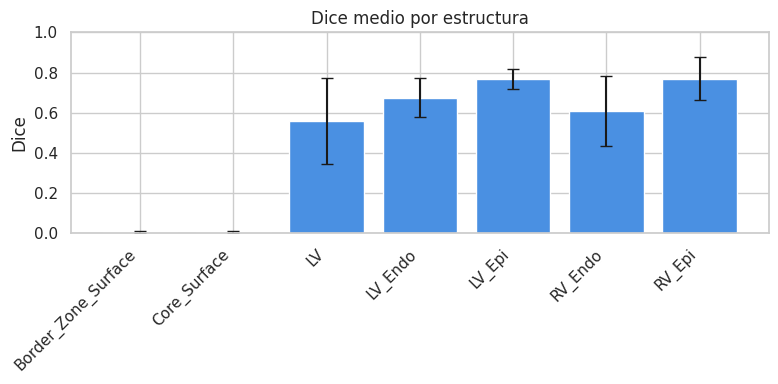

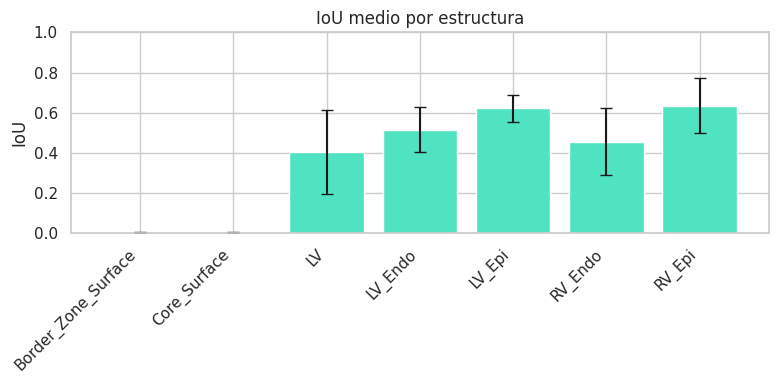


Se guardó el detalle en: /content/drive/MyDrive/tfm_alvaro/output_test/metrics_por_caso.csv
Se guardó el resumen en: /content/drive/MyDrive/tfm_alvaro/output_test/metrics_resumen.csv


In [36]:
from IPython.display import display
import seaborn as sns

if not results:
    print("No se generaron predicciones. Revise que existan modelos y máscaras en las carpetas indicadas.")
else:
    results_df = pd.DataFrame(results)
    results_csv = OUTPUT_ROOT / "metrics_por_caso.csv"
    results_df.to_csv(results_csv, index=False)

    summary_df = results_df.groupby("heart_part").agg({
        "dice": ["mean", "std"],
        "iou": ["mean", "std"],
        "pred_volume_ml": ["mean", "std"],
        "gt_volume_ml": ["mean", "std"],
    })
    summary_df.columns = ["_".join(col).strip() for col in summary_df.columns.values]
    summary_df = summary_df.reset_index()
    summary_csv = OUTPUT_ROOT / "metrics_resumen.csv"
    summary_df.to_csv(summary_csv, index=False)

    print("\nResultados por caso:")
    display(results_df.sort_values(["heart_part", "patient_id"]).reset_index(drop=True))

    print("\nResumen por estructura:")
    display(summary_df)

    # Gráfico de barras para Dice
    plt.figure(figsize=(10, 6))
    sns.barplot(x="heart_part", y="dice_mean", yerr=summary_df["dice_std"], data=summary_df, palette="viridis", capsize=0.2)
    plt.ylabel("Dice")
    plt.title("Dice medio por estructura")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    # Gráfico de barras para IoU
    plt.figure(figsize=(10, 6))
    sns.barplot(x="heart_part", y="iou_mean", yerr=summary_df["iou_std"], data=summary_df, palette="viridis", capsize=0.2)
    plt.ylabel("IoU")
    plt.title("IoU medio por estructura")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    # Gráfico de barras comparativo para Volúmenes (mejorado)
    volume_melted = summary_df.melt(id_vars="heart_part", value_vars=["gt_volume_ml_mean", "pred_volume_ml_mean"],
                                    var_name="Volume Type", value_name="Mean Volume (ml)")
    volume_melted["Volume Type"] = volume_melted["Volume Type"].replace({
        "gt_volume_ml_mean": "Real (GT)",
        "pred_volume_ml_mean": "Predicho"
    })

    plt.figure(figsize=(12, 7))
    sns.barplot(x="heart_part", y="Mean Volume (ml)", hue="Volume Type", data=volume_melted, palette="plasma")
    plt.ylabel("Volumen medio (ml)")
    plt.title("Volumen medio real vs. predicho por estructura")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


    print(f"\nSe guardó el detalle en: {results_csv}")
    print(f"Se guardó el resumen en: {summary_csv}")

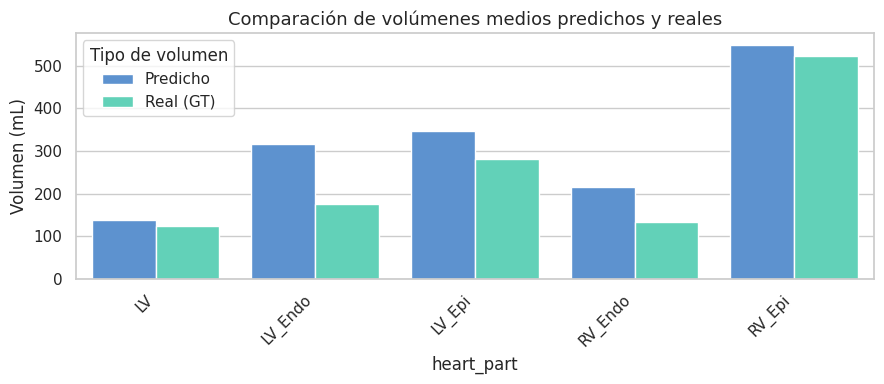

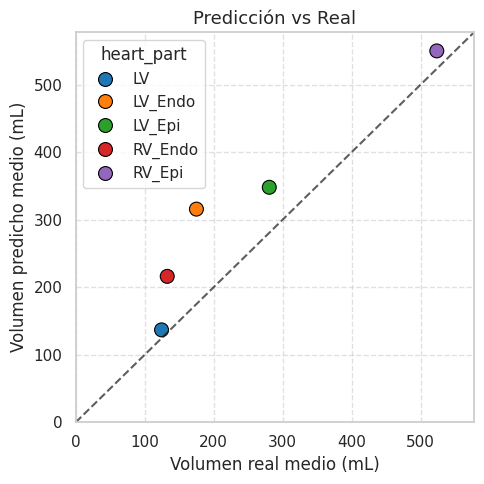

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar estructuras que no quieres incluir
filtered_summary = summary_df[~summary_df["heart_part"].isin(["Border_Zone_Surface", "Core_Surface"])]

# Comprobar que existen las columnas necesarias
if {"pred_volume_ml_mean", "gt_volume_ml_mean"}.issubset(filtered_summary.columns):
    sns.set(style="whitegrid", font_scale=1.0)

    # 1️⃣ Gráfico de barras agrupadas (Predicho vs Real)
    plt.figure(figsize=(9, 4))
    melted_vol = filtered_summary.melt(
        id_vars="heart_part",
        value_vars=["pred_volume_ml_mean", "gt_volume_ml_mean"],
        var_name="Tipo de volumen",
        value_name="Volumen (mL)"
    )

    melted_vol["Tipo de volumen"] = melted_vol["Tipo de volumen"].replace({
        "pred_volume_ml_mean": "Predicho",
        "gt_volume_ml_mean": "Real (GT)"
    })

    sns.barplot(
        data=melted_vol,
        x="heart_part", y="Volumen (mL)",
        hue="Tipo de volumen",
        palette=["#4a90e2", "#50e3c2"],
        capsize=0.2
    )
    plt.title("Comparación de volúmenes medios predichos y reales", fontsize=13)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 2️⃣ Gráfico de dispersión (Predicho vs Real)
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        data=filtered_summary,
        x="gt_volume_ml_mean",
        y="pred_volume_ml_mean",
        hue="heart_part",
        s=100,
        palette="tab10",
        edgecolor="black"
    )

    # Línea diagonal de igualdad
    lims = [
        0,
        max(filtered_summary["gt_volume_ml_mean"].max(), filtered_summary["pred_volume_ml_mean"].max()) * 1.05
    ]
    plt.plot(lims, lims, 'k--', alpha=0.7)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel("Volumen real medio (mL)")
    plt.ylabel("Volumen predicho medio (mL)")
    plt.title("Predicción vs Real", fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontraron las columnas necesarias en summary_df.")
